**Steps**

1. Install and load libraries and packages.


In [31]:
#If you receive an error running this cell for the first time, try running it agian. 

import csv
import warnings
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from pprint import pprint

import requests
from time import sleep

WORKS_ENDPOINT = "https://api.openalex.org/works?"
SEARCH_ENDPOINT = "https://api.openalex.org/search?"
API_KEY = ""
header = {
        "apikey": API_KEY,
    }
RESULTS_PER_PAGE = 200 #without api key, maximum is 200 results per page

In [ ]:
PATH_TO_INPUT_CSV = "../../authorlist.csv"

In [32]:
def get_api_response(param, url):
    try:
        response = requests.get(url=url, headers=header, params=param)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.HTTPError as errh:
        print("Http Error:", errh)
    except requests.exceptions.ConnectionError as errc:
        print("Error Connecting:", errc)
    except requests.exceptions.Timeout as errt:
        print("Timeout Error:", errt)
    except requests.exceptions.RequestException as err:
        print("Something Else", err)
    except ValueError as e: 
        print("Decoding JSON has failed:", e)
        print("Raw Response:", response.text)

2. Modify the names of the input and output files. The name of the input file should match the name of the author list CSV file. If you followed the setup instructions, the CSV file should now be in the same directory as this notebook file. The output file does not have to exist yet (it will be created). 

In [33]:
# !!! Modify this to match the name of your author list CSV file. 
author_list_csv = "oa_authorlist.csv"
output_data_csv = "Outputs/oa_ss_output_data.csv"

3. Load in the author names from the CSV file. 

In [36]:
authorlist_df = pd.read_csv(author_list_csv,sep="|")

4. Modify the affiliations list with institutions which the researchers are affiliated with. 

5. Scrape data for each author. This will take several minutes. 

In [37]:
## with document type
DOCUMENT_SEP = ";;" #separate each document type from the title 
def get_all_document_titles(author_id) -> list:
    works = get_api_response({
        "filter": f"author.id:{author_id}",
        'per_page': RESULTS_PER_PAGE,
    }, url=WORKS_ENDPOINT)

    documents = [f'{work["title"]}{DOCUMENT_SEP}{work["type"]}' for work in works["results"]]
    total_works = works["meta"]["count"]
    if total_works > RESULTS_PER_PAGE:
        more_pages = int(total_works/RESULTS_PER_PAGE)
        for page in range(2, more_pages+2): #start at page 2
            sleep(1)
            addl_works = get_api_response({
                "filter": f"author.id:{author_id}",
                'per_page': RESULTS_PER_PAGE,
                "page": page,
            }, url=WORKS_ENDPOINT)
            documents += [f'{work["title"]}{DOCUMENT_SEP}{work["type"]}' for work in addl_works["results"]]

    return documents

In [38]:
# This will contain all the data for each author which will be exported as a table. It will be a list of dictionaries. 
rows = []
# This will contain a list of dictionaries for each author. The dictionaries will be made up of years as keys and citation numbers as vals
cites_per_year = []
# This dictionary will contain publication titles as keys and author names as values
pub_authors = {}


for idx, athr in authorlist_df.iterrows():
    sleep(1)
    used_athr_ID = False
    author_name = str(athr["Authorlist Name"])
    openalex_id = str(athr['Author ID'])
    print(f"getting documents for {author_name}...")

    # Get publications titles 
    pubs = get_all_document_titles(openalex_id)
    print(f"found {len(pubs)} entries")
    
    for document in pubs:
        # Add to dictionary with title as key and author as value
        if (document not in pub_authors.keys()) or (author_name not in pub_authors[document]): 
            pub_authors.setdefault(document, []).append(author_name)

    row = {'Name': author_name, 
            'Author ID': openalex_id,
        #    'Publications': pubs,
            'Document Count': len(pubs),
            }
        # Create list of authors who do not have the specified affiliation
    print("complete\n")
    rows.append(row)
                

getting documents for Tim H. Murphy...
found 236 entries
complete

getting documents for Annie Ciernia...
found 47 entries
complete

getting documents for Brian MacVicar...
found 151 entries
complete

getting documents for Fidel Vila-Rodriguez...
found 176 entries
complete

getting documents for Shernaz Bamji...
found 57 entries
complete

getting documents for Lara Boyd...
found 301 entries
complete

getting documents for Paul Pavlidis...
found 278 entries
complete

getting documents for Martin McKeown...
found 166 entries
complete

getting documents for A Jon Stoessl...
found 244 entries
complete

getting documents for Peter Cripton...
found 174 entries
complete

getting documents for Jason Snyder...
found 60 entries
complete

getting documents for Wolfram Tetzlaff...
found 246 entries
complete

getting documents for Anthony Phillips...
found 340 entries
complete

getting documents for Catharine Winstanley...
found 147 entries
complete

getting documents for Yu Tian Wang...
found 262 

6. Add coauthors to the rows. 

In [39]:
# Create dictionary with author names as keys and dictionary (coauthor name as key, number of collaborations as value) 
#   as value
collabs_dict={}
for key in pub_authors:
    for author in pub_authors[key]:
        for coauthor in pub_authors[key]:
            if coauthor is not author:
                if author not in collabs_dict.keys() or coauthor not in collabs_dict[author].keys():
                    collabs_dict.setdefault(author,{})[coauthor]=1
                else:
                    collabs_dict[author][coauthor]+=1


# Write to rows dataframe
for row in rows:
    if row['Name'] in collabs_dict.keys():
        row['Coauthors'] = collabs_dict[row['Name']]

        

In [40]:
coauthored_pubs = [
    title
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_authors = [
    authors
    for title, authors in pub_authors.items() 
    if len(authors) > 1]

coauthored_df = pd.DataFrame({"Title": coauthored_pubs, "Authors": coauthored_authors})

print(coauthored_df.head())

coauthored_df.to_csv("Outputs/oa_shared_pubs.csv",index=False)

                                               Title  \
0  Early Increase in Extrasynaptic NMDA Receptor ...   
1  A Small-Molecule-Inducible Nrf2-Mediated Antio...   
2  Spontaneous cortical activity alternates betwe...   
3  Extensive Turnover of Dendritic Spines and Vas...   
4  <i>In Vivo</i>Voltage-Sensitive Dye Imaging in...   

                                        Authors  
0                 [Tim H. Murphy, Lynn Raymond]  
1                    [Tim H. Murphy, Andy Shih]  
2  [Tim H. Murphy, Yu Tian Wang, Jeffrey LeDue]  
3               [Tim H. Murphy, Craig E. Brown]  
4               [Tim H. Murphy, Craig E. Brown]  


7. Write rows to output CSV file

In [41]:
# Specify the order of the data. These keys must match the names of the keys in the rows dictionary. 
# keys = ['Name', 'Scholar ID', 'Document Count', 'Cited by', 'Cited by 5 years', 'h-index', 'h-index 5 years',  'i10-index', 'i10-index 5 years', 'Publications', 'Coauthors', 'Affiliation', 'Warning']
keys = ['Name', 
        'Author ID',
        'Document Count',
        # 'Publications',
        'Coauthors',]

# This creates/opens the file with filename with the intention to write to the csv_file
# The encoding allows the characters to be properly written to the csv_file
with open(output_data_csv, mode='w', encoding ="utf-8", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer = csv.DictWriter(csv_file, keys, delimiter='|', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dict_writer.writeheader()
    dict_writer.writerows(rows)

8. Create barplot of citations per year. Modify the years and output PDF filename. 

In [25]:
# # Create citations per year dataframe
# cites_df = pd.DataFrame(cites_per_year)

# # Add a totals column
# cites_df.loc['Total']= cites_df.sum()

# # Select years to plot
# cites_df_selected = cites_df[[2018,2019,2020,2021,2022,2023]]

# # Select the last row (totals) 
# cites_df_total = cites_df_selected.iloc[-1:]

# # Create barplot
# years = list(cites_df_total.columns)
# cites = cites_df_total.values.tolist()[0]
# plt.bar(years, cites )
# plt.ylabel('Total Citations')

# # !!! Modify this - name the output PDF file
# # plt.savefig(bargraph_output)
# plt.savefig("sv_bargraph.csv")

9. Create collaboration heatmap

['Tim H. Murphy', 'Lynn Raymond', 'Andy Shih', 'Yu Tian Wang', 'Jeffrey LeDue', 'Craig E. Brown', 'Brian MacVicar', 'Wolfram Tetzlaff', 'Helge Rhodin', 'Ian Mackenzie', 'Annie Ciernia', 'Paul Pavlidis', 'Anthony Phillips', 'Shernaz Bamji', 'Silke Cresswell', 'Leigh Anne Swayne', 'Fidel Vila-Rodriguez', 'Sophia Frangou', 'Jason Snyder', 'Kurt Haas', 'Catharine Rankin', 'Lara Boyd', 'Martin McKeown', 'A Jon Stoessl', 'Vesna Sossi', 'Todd Woodward', 'Z. Jane Wang', 'Catharine Winstanley', 'Terry Snutch', 'Peter Cripton', 'Mark Cembrowski', 'Fabio Rossi', 'Jane Roskams', 'Jeremy Seamans', 'Michael Gordon', 'Ilker Hacihaliloglu', 'Purang Abolmaesumi', 'Randy Mcintosh', 'Leonid Sigal', 'Peyman Servati', 'Brian D. Fisher', 'Adrienne Fairhall', 'Eric Shea-Brown']


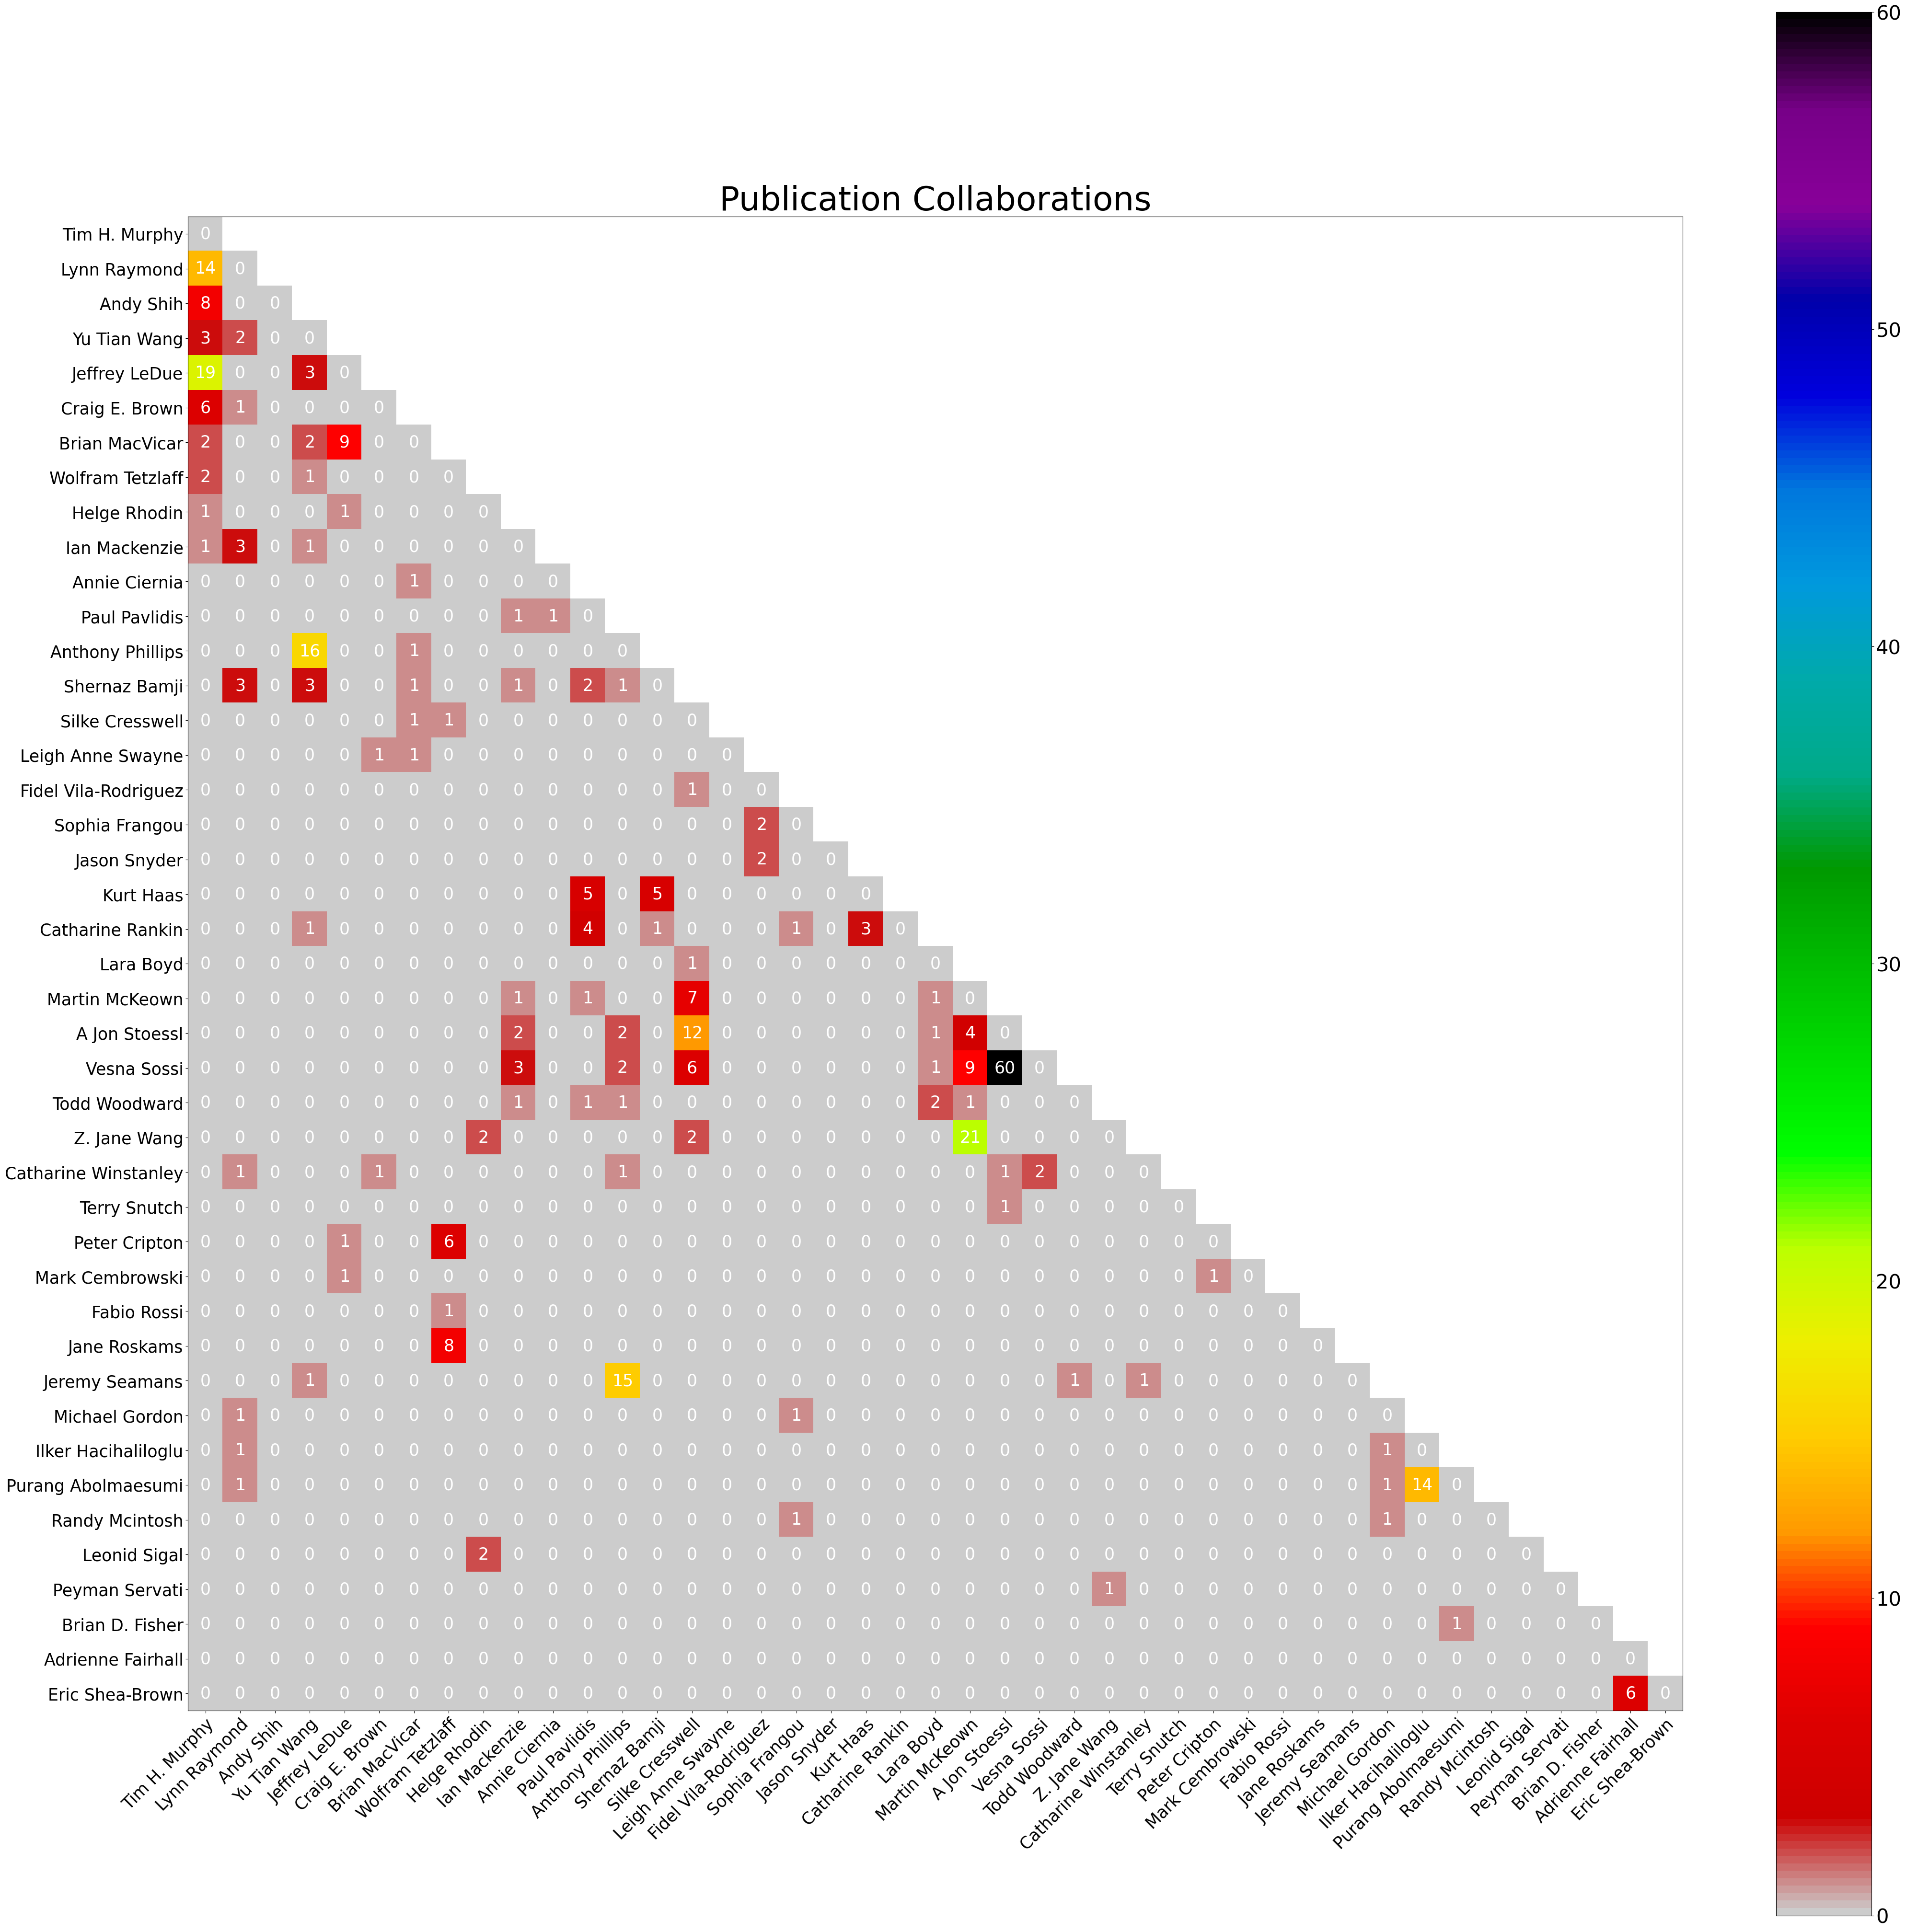

In [42]:
authors = list(collabs_dict.keys())
print(authors)
author_count=len(authors)
# Initialize array with zeros. 
collabs_array = np.zeros((author_count, author_count), dtype=int)

# Populate the array with the number of collaborations between authors
for i, athr in enumerate(authors):
    for j, name in enumerate(authors):
        if name in collabs_dict[athr].keys():
            collabs_array[i][j] = collabs_dict[athr][name]
            
# Only display the lower triangle of the matrix
mask =  np.tri(collabs_array.shape[0], k=-1)
collabs_array = np.ma.array(collabs_array, mask=mask).T

# Set up the colourmap 
cmap = plt.colormaps['nipy_spectral']
cmap = cmap.reversed()

### Create heatmap ###

fig = plt.figure(figsize = (author_count,author_count)) 
ax = fig.add_subplot(111)
im = ax.imshow(collabs_array, cmap=cmap, interpolation='nearest', 
               #norm=matplotlib.colors.LogNorm()            # Uncomment this if you want a logarithmic colormap
              )

# Show the ticks
ax.set_xticks(np.arange(author_count))
ax.set_yticks(np.arange(author_count))

# Label the ticks with author names - you can modify the authorname font size here
ax.set_xticklabels(authors,fontsize=25)
ax.set_yticklabels(authors, fontsize=25)

# Rotate and align tick labels.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create numeric annotations.
for i in range(author_count):
    for j in range(author_count):
        text = ax.text(j, i, collabs_array[i, j],
                       ha="center", va="center", color="w", fontsize=25)
# Fit plot within figure        
fig.tight_layout()


# Add title - you can change the title and title font size here
ax.set_title("Publication Collaborations", fontsize = 50)

# Add the colorbar and add ticks - change colorbar label fontsize here
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=30)

# Save the figure as PDF - you can modify the filename here. 
# plt.savefig(figure_output)
plt.savefig("Outputs/Graphs/oa_heatmap.pdf")

plt.show()
